In [98]:
import psycopg2
import matplotlib.pyplot as plt

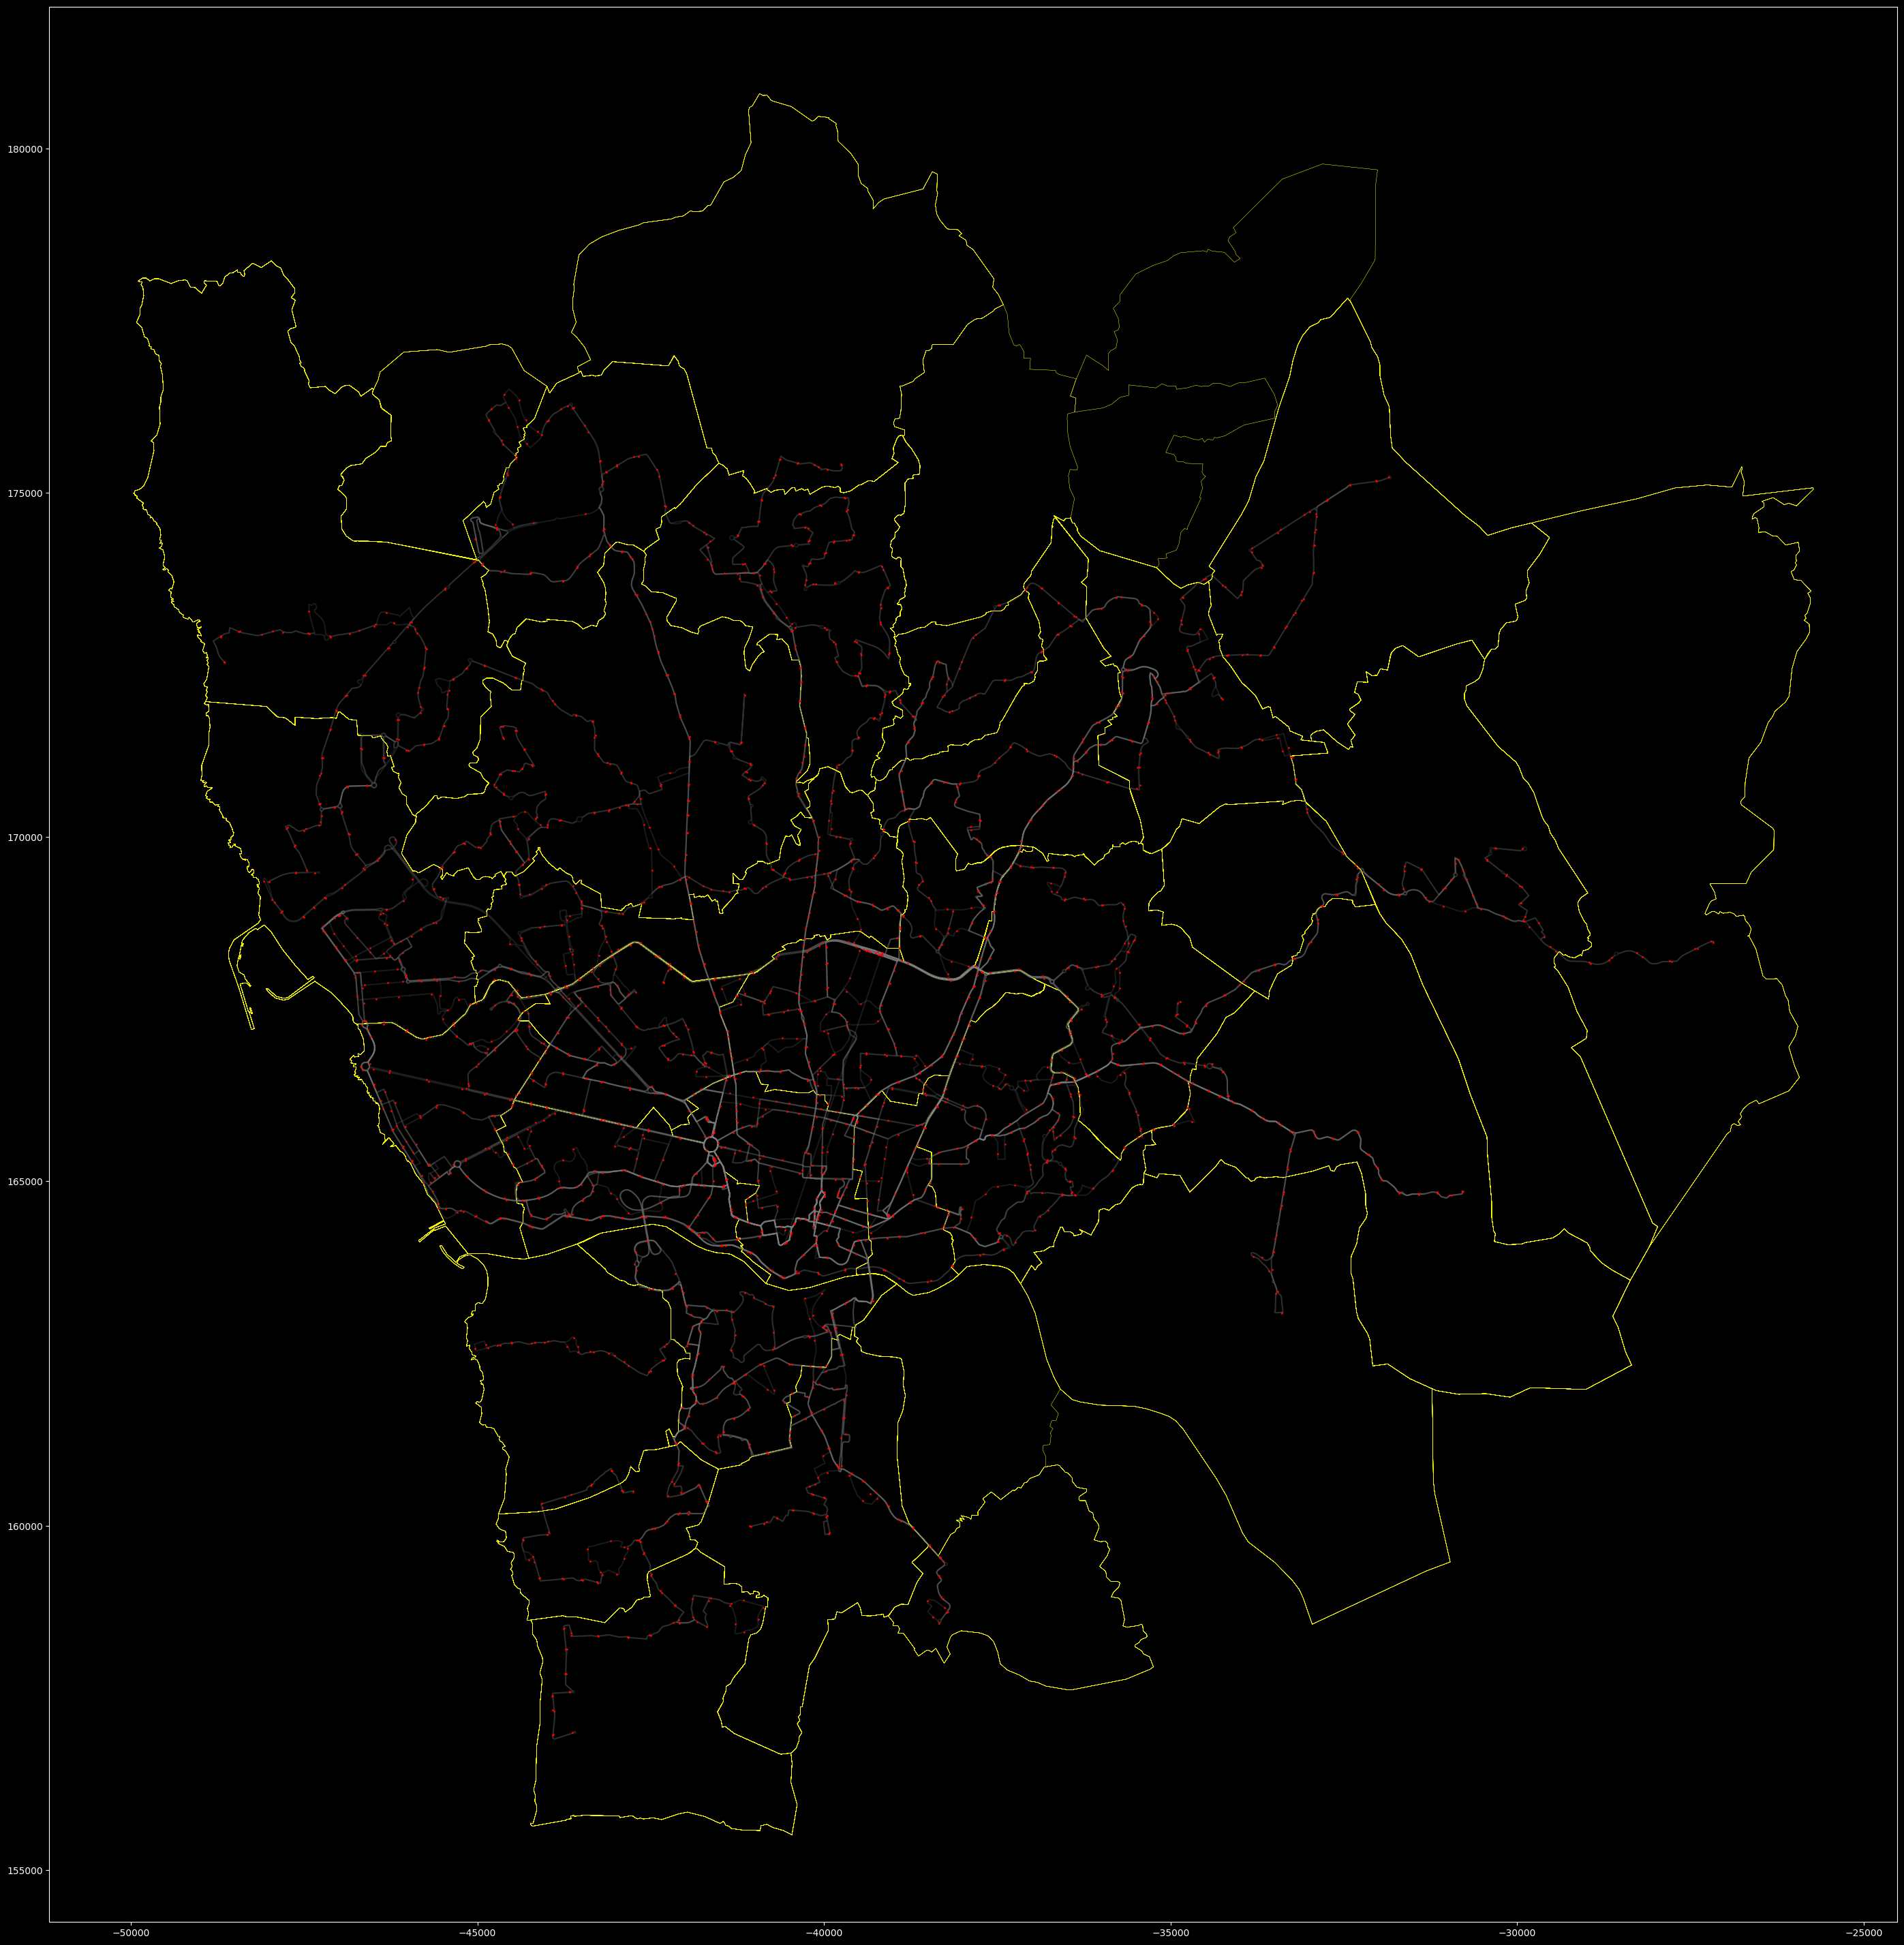

In [109]:
plt.style.use('dark_background')

xmin = -49964.492999999784
xmax = -25724.446600000374
ymin = 155509.45260000043
ymax = 180795.91699999943

scale = 1/30000
width_in_inches = ((xmax - xmin)/0.0254)*1.1
height_in_inches = ((ymax - ymin)/0.0254)*1.1

fig = plt.figure(figsize=(width_in_inches*scale, height_in_inches*scale))
conn = psycopg2.connect("dbname=project user=hugens")
cursor_psql = conn.cursor()

######################### 
# plot only the relevant parished, i.e. the ones the STCP bus goes by
#########################

sql = """
select st_astext(st_simplify(proj_boundary,10))
from cont_aad_caop2018
join (
select st_transform(st_setsrid(st_point(stop_lon, stop_lat), 4326), 3763) as geom
from stops
) as transformed_geom on st_contains(proj_boundary, transformed_geom.geom)
where distrito = 'PORTO';
"""

cursor_psql.execute(sql)
results = cursor_psql.fetchall()

#xmin,xmax = 0,-40000
#ymin,ymax = 170000,0

for row in results:
    xs = []
    ys = []
    points_string = row[0]
    points_string = points_string[9:-2].split(",")
    for point in points_string:
        (x,y) = point.split()
        xs.append(float(x))
        ys.append(float(y))
    plt.plot(xs,ys, color='yellow',linewidth=0.2)
    #xmin = min(xmin, min(xs))
    #xmax = max(xmax, max(xs))
    #ymin = min(ymin, min(ys))
    #ymax = max(ymax, max(ys))
#print(f"xmin {xmin}, xmax {xmax}")
#print(f"ymin {ymin}, ymax {ymax}")

######################### 
# plot the bus routes
######################### 

ids = {}
id = 0
sql = "SELECT shape_id from shapes;"
cursor_psql.execute(sql)
results = cursor_psql.fetchall()

shapes = []

id = 0
for s in results:
    ids[s[0]] = id
    id += 1
    shapes.append([])

sql = """
select shape_id, 
st_astext(st_transform(st_setsrid(st_point(shape_pt_lon, shape_pt_lat), 4326), 3763)) as geometry,
shape_pt_sequence
from shapes
"""
cursor_psql.execute(sql)
results = cursor_psql.fetchall()

dic = {}
dic_id = 0

for result in results:
    id_p = result[0]
    id_s = ids[id_p]
    sequence = int(result[2])
    ps = result[1][6:-1].split()
    x = float(ps[0])
    y = float(ps[1])
    shapes[id_s].append((sequence,x,y))

for s in shapes:
    s = sorted(s,key=lambda x:s[0])

for row in shapes:
    xs = []
    ys = []
    for p in row:
        x = float(p[1])
        y = float(p[2])
        xs.append(x)
        ys.append(y)
    plt.plot(xs,ys,color='gray',alpha=0.2)

######################### 
# plot the bus stops
######################### 

sql = """
select st_astext(st_transform(st_setsrid(st_point(stop_lon,stop_lat),4326),3763))
from stops
"""
cursor_psql.execute(sql)
results = cursor_psql.fetchall()

xs = []
ys = []
for row in results:
    point_string = row[0]
    point_string = point_string[6:-1]
    x,y = point_string.split(" ")
    xs.append(float(x))
    ys.append(float(y))
plt.scatter(xs,ys,s=1,zorder=3,color='red')